# Combine sgRNAs
Here we get a dataframe of all sgRNAs for all processed datasets to use for scoring

In [1]:
import pandas as pd
from datasets import dataset_list
from scipy import stats
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib as mpl
import gpplot
import seaborn as sns

from core import (add_xy_line,
                  setup_plots)

We need to load the datasets first

In [2]:
setup_plots()

In [3]:
for ds in dataset_list:
    ds.load_data()

In [4]:
dataset_summaries = []
for ds in dataset_list:
    ds_summary = dict()
    ds_summary['name'] = ds.name
    ds_summary['n_sgRNAs'] = ds.dataset.shape[0]
    if ds.sgrna_group_col is not None:
        ds_summary['n_groups'] = ds.dataset[ds.sgrna_group_col].nunique()
    dataset_summaries.append(ds_summary)

dataset_summary_df = pd.DataFrame(dataset_summaries)
dataset_summary_df.sort_values('n_sgRNAs')

,name,n_sgRNAs,n_groups
6,Kim2019_test,536,NaN
3,Doench2014_human,995,3.0
9,Wang2014,1022,29.0
2,Doench2014_mouse,1169,7.0
1,Chari2015,1202,NaN
4,Doench2016,2536,8.0
8,Shalem_2014,4766,1249.0
7,Koike-Yusa2014,6689,1437.0
0,Aguirre2017,8659,1532.0
10,Xiang2021,11397,NaN


## Overlap between datasets

For each dataset we'll calculate the fraction of sgRNAs that each library shares with one another.

### Activity of overlapping sgRNAs

Most datasets show agreement between the activity of overlapping sgRNAs, except for the Shalem dataset
(GeckoV1), which typically showed lower correlation values.

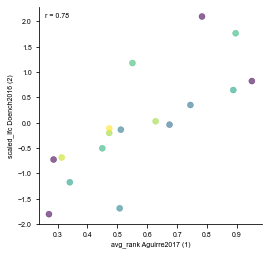

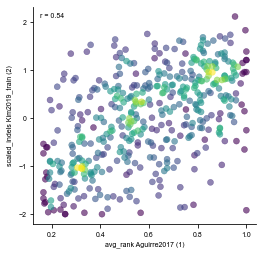

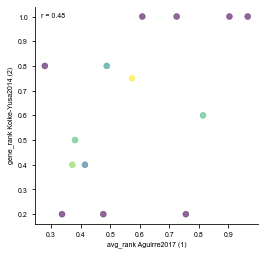

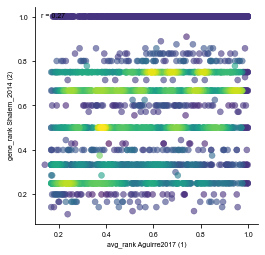

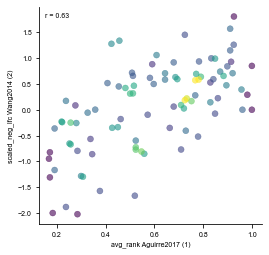

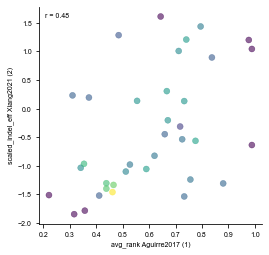

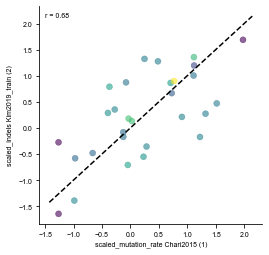

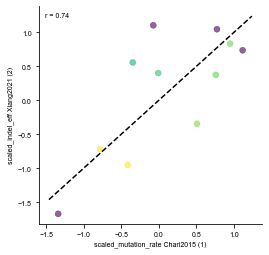

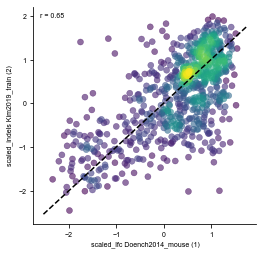

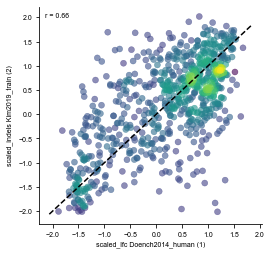

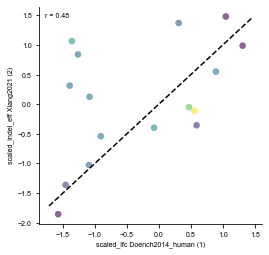

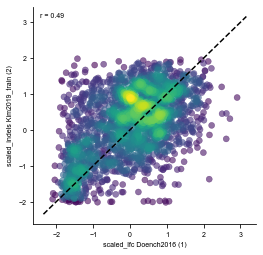

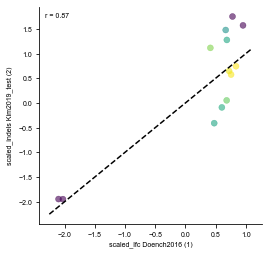

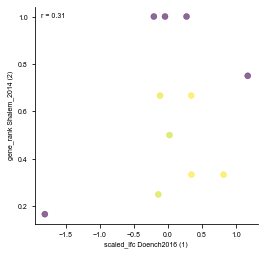

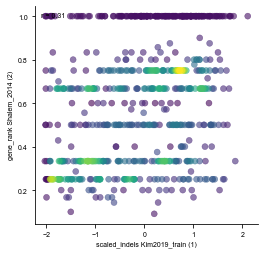

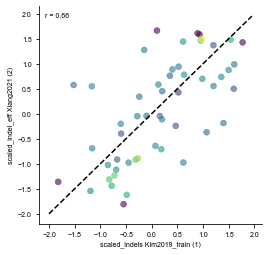

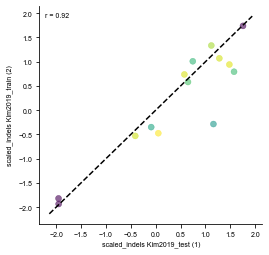

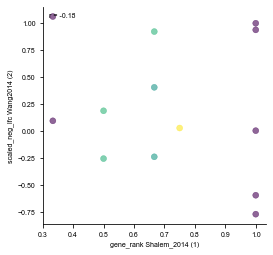

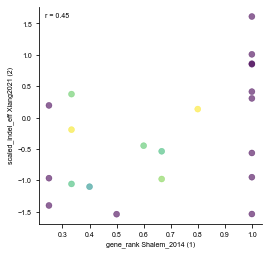

In [5]:
dataset_overlaps = []
for ds1 in dataset_list:
    for ds2 in dataset_list:
        if ds1 != ds2:
            dataset_overlap = dict()
            dataset_overlap['name_1'] = ds1.name
            dataset_overlap['name_2'] = ds2.name
            common_context = (ds1.dataset[ds1.context_seq_col]
                              .isin(ds2.dataset[ds2.context_seq_col])
                              .sum())
            dataset_overlap['overlap'] = common_context
            if common_context > 10:
                ds1_rename = ds1.rank_col + ' ' + ds1.name + ' (1)'
                ds2_rename = ds2.rank_col + ' ' + ds2.name + ' (2)'
                merged_data = (ds1.dataset
                               .rename({ds1.rank_col: ds1_rename}, axis=1)
                               .merge(ds2.dataset
                                      .rename({ds2.rank_col: ds2_rename}, axis=1),
                                      how='inner',
                                      left_on=ds1.context_seq_col, right_on=ds2.context_seq_col))
                if ds1.name < ds2.name:
                    plt.subplots(figsize=(4, 4))
                    gpplot.point_densityplot(merged_data, x=ds1_rename,
                                             y=ds2_rename)
                    gpplot.add_correlation(merged_data, x=ds1_rename,
                                           y=ds2_rename)
                    sns.despine()
                    if ('scaled' in ds1.rank_col) and ('scaled' in ds2.rank_col):
                        add_xy_line()
                cor = stats.pearsonr(merged_data[ds1_rename],
                                     merged_data[ds2_rename])[0]
                dataset_overlap['activity_cor'] = cor
            dataset_overlaps.append(dataset_overlap)

dataset_overlap_df = pd.DataFrame(dataset_overlaps)
filtered_overlap = dataset_overlap_df[dataset_overlap_df['overlap'] > 0].reset_index(drop=True)
# directional overlap
filtered_overlap = (filtered_overlap.merge(dataset_summary_df
                                           .rename({'name': 'name_1'}, axis=1),
                                           how='inner', on='name_1'))
filtered_overlap['fraction_overlap'] = filtered_overlap['overlap']/filtered_overlap['n_sgRNAs']

AttributeError: 'PatchCollection' object has no property 'vmin'

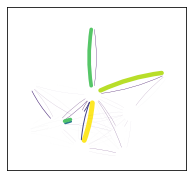

In [14]:
G = nx.from_pandas_edgelist(filtered_overlap, 'name_1', 'name_2', 'fraction_overlap',
                            create_using=nx.DiGraph())
node_n_sgrnas = (dataset_summary_df[['name', 'n_sgRNAs']]
                 .set_index('name')
                 .to_dict(orient='index'))
nx.set_node_attributes(G, node_n_sgrnas)
plt.subplots(figsize=(3.2,3))
# layout
pos = nx.spring_layout(G, seed=2)
# edges
edge_width = [d['fraction_overlap']*6 for u, v, d in G.edges(data=True)]
edge_color_scale = [d['fraction_overlap'] for u, v, d in G.edges(data=True)]
edges = nx.draw_networkx_edges(G, pos, arrowstyle="-", connectionstyle="arc3,rad=0.1",
                               width=edge_width, edge_color=edge_color_scale,
                               arrowsize=5)
pc = mpl.collections.PatchCollection(edges, cmap=plt.cm.viridis,  vmin=0, vmax=1)
pc.set_array(edge_color_scale)
plt.colorbar(pc, label='Fraction Overlap')
# nodes
node_size = [d['n_sgRNAs'] * 0.02 for n, d in G.nodes(data=True)]
nx.draw_networkx_nodes(G, pos, node_size=node_size)
# labels
nx.draw_networkx_labels(G, pos, font_size=7,
                        font_family='Arial')
plt.axis('off')
plt.margins(x=0.2)
gpplot.savefig('../figures/dataset_overlap.pdf')

## Getting list of all sgRNAs

In [7]:
sgrna_dfs_list = list()
for ds in dataset_list:
    print(ds.name)
    sgrna_dfs_list.append(ds.get_sg_df())

sgrna_df = (pd.concat(sgrna_dfs_list)
            .drop_duplicates())

print(sgrna_df.shape[0])

Aguirre2017
Chari2015
Doench2014_mouse
Doench2014_human
Doench2016
Kim2019_train
Kim2019_test
Koike-Yusa2014
Shalem_2014
Wang2014
Xiang2021
44389


In [8]:
sgrna_df['PAM Sequence'].value_counts()

TGG    16871
AGG    14228
CGG     7108
GGG     6182
Name: PAM Sequence, dtype: int64

In [9]:
lower_seqs = sgrna_df.loc[sgrna_df['sgRNA Context Sequence'].str.contains('a|c|t|g'), 'sgRNA Sequence']
for ds in dataset_list:
    ds.set_sgrnas()
    if pd.Series(list(ds.sgrnas)).isin(lower_seqs).any():
        print(ds.name)

In [10]:
sgrna_df

,sgRNA Sequence,sgRNA Context Sequence,PAM Sequence
0,AAAAAACTTACCCCTTTGAC,AAAAAAAAAACTTACCCCTTTGACTGGCCA,TGG
1,AAAAACATTATCATTGAGCC,TGGCAAAAACATTATCATTGAGCCTGGATT,TGG
2,AAAAAGAGATTGTCAAATCA,TATGAAAAAGAGATTGTCAAATCAAGGTAG,AGG
3,AAAAAGCATCTCTAGAAATA,TTCAAAAAAGCATCTCTAGAAATATGGTCC,TGG
4,AAAAAGCGAGATACCCGAAA,AAAAAAAAAGCGAGATACCCGAAAAGGCAG,AGG
...,...,...,...
11392,AGTGGAGAATTCTGGAAAGG,CAGGAGTGGAGAATTCTGGAAAGGTGGACA,TGG
11393,GAAGATGGATGTGTCAGTGA,TGATGAAGATGGATGTGTCAGTGAGGGCCG,GGG
11394,TGGTGAAACTTTCATCCTGT,CACCTGGTGAAACTTTCATCCTGTAGGTTC,AGG
11395,TGGTTGTAGTTCCCTCTGTT,TACCTGGTTGTAGTTCCCTCTGTTGGGCAT,GGG


In [11]:
# write fasta for crispron
with open('../data/interim/rs_dev_all_sgrnas.fa', 'w') as f:
    for context in sgrna_df['sgRNA Context Sequence']:
        f.write('>' + context + '\n')
        f.write(context + '\n')

In [12]:
sgrna_df.to_csv('../data/interim/rs_dev_all_sgrnas.csv', index=False)
filtered_overlap.to_csv('../data/processed/dataset_overlap.csv', index=False)